### Import and Clean Poems

### Input file -> list of poems, where poem is list 

In [1]:
import string
import pandas as pd
from Bio import Phylo
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import pronouncing as prn
import gensim
import scipy
import ete3
from skbio import DistanceMatrix
from skbio.tree import nj

In [2]:
# Returns a list of poems, lowecase, no punctuation
def make_poems_list(file_in):
    with open(file_in, 'r') as file:
        poems_list = file.read().split('\n\n')
        # Get rid of poem titles, /n characters, and make characters lowercase
        poems = [item.translate(str.maketrans('\n',' ',string.punctuation)).lower() for item in poems_list[1::2]]
            
    return poems

In [3]:
poems_list = make_poems_list('sonnets.txt')
#poems_list = poems_list_words[:20]
#poems_list[20]

### Input file -> list of poems, where poem is list of lists

In [4]:
# Returns a list of lists with text lowecase, no punctuation
def make_poems_lines(file_in):
    
    '''Takes a text file of poems, returns a list of poems with titles and no punctuation'''
    
    poems = []    
    with open(file_in, 'r') as file:
        poems_raw = file.read().split('\n\n')
        poems_clean = [poem.split('\n')for poem in poems_raw]
        for i in range(0, (int(len(poems_clean) - 1)), 2):
            poem = poems_clean[i+1]
            poems.append(poem)
            
    poems_clean = []
    for poem in poems:
        poem_clean = []
        for line in poem:
            poem_no_punc = line.translate(str.maketrans('','',string.punctuation)).rstrip().lower()
            poem_no_punc = line
            poem_clean.append(poem_no_punc)

            
        poems_clean.append(poem_clean)

    return poems_clean

In [5]:
poems_lines = make_poems_lines('sonnets.txt')
#poems_lines = poems_lines[:20]

### Words to Phonemes

In [6]:
# Returns list of poems with phonemes instead of words, and list of slang words
def poems_to_phones(poems):
    poems_phones = []
    poems_slang = []
    
    for poem in poems:
        poem_phones = ""
        poem_slang = []
        
        words = poem.split()
        for word in words:
            p = prn.phones_for_word(word)
            if len(p) == 1: # there is only one pronunciation
                poem_phones = poem_phones + p[0] + " "
            elif len(p) > 1: # there is more than one pronunciation
                # TODO fix this hack by figuring out which pronunciation is best instead of just choosing the 1st
                poem_phones = poem_phones + p[0] + " "
            else: # the word is not in the pronouncing dictionary
                poem_slang.append(word)
                poem_phones = poem_phones + " "
        
        poems_slang.append(poem_slang)    
        poems_phones.append(poem_phones)
        
    return poems_phones, poems_slang

In [95]:
phonemes, slang = poems_to_phones(poems_list)
#phonemes

In [103]:
def poems_to_phonemes_list(poems):
    poems_phones = []
    poems_slang = []
    
    for poem in poems:
        poem_phones = [""]
        poem_slang = []
        
        for line in poem:
            line_phones = ""
            words = line.split()
            for word in words:
                p = prn.phones_for_word(word)
                if len(p) == 1: # there is only one pronunciation
                    line_phones = line_phones + p[0] + " "
                elif len(p) > 1: # there is more than one pronunciation
                    # TODO fix this hack by figuring out which pronunciation is best instead of just choosing the 1st
                    line_phones = line_phones + p[0] + " "
                else: # the word is not in the pronouncing dictionary
                    poem_slang.append(word)
                    line_phones = line_phones + " "
                    
            poem_phones.append(line_phones)
        
        poems_slang.append(poem_slang)    
        poems_phones.append(poem_phones)
        
    return poems_phones, poems_slang

In [104]:
phonemes_list, slang = poems_to_phonemes_list(poems_lines)
phonemes_list

[['',
  'F R AH1 M F EH1 R IH0 S T K R IY1 CH ER0 Z W IY1 D IH0 Z AY1 ER0  ',
  'DH AE1 T DH EH1 R B AY1  R OW1 Z M AY1 T N EH1 V ER0  ',
  'B AH1 T AE1 Z DH AH0  SH UH1 D B AY1 T AY1 M  ',
  'HH IH1 Z T EH1 N D ER0 EH1 R M AY1 T B EH1 R HH IH1 Z  ',
  'B AH1 T  K AA1 N T R AE0 K T AH0 D T UW1 DH AY1 N OW1 N B R AY1 T  ',
  ' DH AY1  F L EY1 M W IH1 DH   ',
  'M EY1 K IH0 NG AH0 F AE1 M AH0 N W EH1 R AH0 B AH1 N D AH0 N S  ',
  'DH AY2 S EH1 L F DH AY1  T UW1 DH AY1 S W IY1 T S EH1 L F T UW1  ',
  'DH AW1 DH AE1 T AA1 R T N AW1 DH AH0 W ER1 L D Z F R EH1 SH AO1 R N AH0 M AH0 N T ',
  'AH0 N D OW1 N L IY0 HH EH1 R AH0 L D T UW1 DH AH0 G AO1 D IY0  ',
  'W IH0 DH IH1 N DH AY1 N OW1 N B AH1 D  DH AY1 K AA1 N T EH0 N T ',
  ' T EH1 N D ER0   W EY1 S T IH0 N  ',
  'P IH1 T IY0 DH AH0  AO1 R EH1 L S DH IH1 S   ',
  'T UW1 IY1 T DH AH0 W ER1 L D Z  B AY1 DH AH0 G R EY1 V AH0 N D  '],
 ['',
  'W EH1 N F AO1 R T IY0 W IH1 N T ER0 Z SH AE1 L  DH AY1  ',
  'AH0 N D D IH1 G D IY1 P T R EH1 N CH IH

### Phonemes to Phoneme Types

In [108]:
# Returns list of poems with phonemes instead of words, and list of slang words
def phones_to_type(poems, just_vc=True, lines=True):
    poems_types = [] 
    
    for poem in poems:
        
        if lines is True:
            for line in poem:
                phones = line.split()
        
        else:
            phones = poem.split()

            
        poem_types = ""
        
        if just_vc:
            for phone in phones:
                if phone in ['F', 'V', 'S', 'Z','HH', 'TH', 'SH', 'ZH', 'JH','P', 'B', 'T', 'D', 'K', 'G', 'CH', 'DH',
                            'M', 'N', 'NG', 'L', 'R', 'W', 'Y' ]:
                    poem_types = poem_types + " cons" + " "
                else:
                    poem_types = poem_types + "vowel" + " "
                
        else:
        
            for phone in phones:
                if phone in ['F', 'V', 'S', 'Z','HH', 'TH', 'SH', 'ZH', 'JH']:
                    poem_types = poem_types + 'fric' + " "
                elif phone in ['P', 'B', 'T', 'D', 'K', 'G', 'CH', 'DH']:
                    poem_types = poem_types + 'plos' + " "
                elif phone in ['M', 'N', 'NG']:
                    poem_types = poem_types + 'nasal' + " "
                elif phone in ['L', 'R', 'W', 'Y']:
                    poem_types = poem_types + 'approx' + " "
                else:
                    poem_types = poem_types + 'vowel' + " "

                

        
        poems_types.append(poem_types)
        
    return poems_types

In [127]:
phon_types_list = phones_to_type(phonemes_list, just_vc=True, lines=True)
phon_types
poem0_ph = phon_types[0]
poem0_ph
phon_types_list

[' cons vowel vowel  cons  cons vowel  cons vowel  cons  cons  cons  cons vowel  cons vowel  cons  cons vowel  cons vowel  cons  cons ',
 'vowel  cons  cons  cons vowel  cons vowel  cons  cons vowel  cons  cons vowel  cons  cons  cons vowel  cons  cons vowel vowel  cons ',
 ' cons vowel vowel  cons  cons  cons vowel  cons vowel  cons vowel  cons  cons vowel  cons  cons vowel  cons ',
 ' cons vowel  cons  cons vowel  cons  cons vowel  cons  cons vowel  cons vowel  cons vowel ',
 ' cons vowel  cons  cons vowel  cons  cons vowel  cons  cons vowel  cons  cons vowel  cons  cons  cons vowel  cons  cons  cons  cons vowel  cons  cons vowel  cons  cons ',
 ' cons vowel  cons vowel  cons vowel  cons  cons  cons vowel  cons  cons  cons vowel  cons  cons vowel  cons  cons  cons vowel  cons  cons vowel  cons  cons  cons vowel  cons ',
 'vowel  cons vowel  cons  cons vowel  cons  cons vowel  cons vowel  cons vowel ',
 ' cons vowel  cons  cons  cons vowel  cons  cons vowel  cons vowel  cons  cons vow

### Make heatmap with sound types

In [156]:
# Map consonants and vowels to 1 and -1
def ph_types_to_num(phones_list):
    types_num = []
    for poem in phones_list:
        poem_types = []
        for phon in poem.split():
            f=lambda x:1 if x == 'cons' else -1
            c = f(phon)
            poem_types.append(c)
        
        types_num.append(poem_types)
    return types_num
    
    #return c
c = ph_types_to_num(phon_types_list)
len(c[100])

25

In [143]:
def find_max_list(list):
    list_len = [len(i) for i in list]
    print(max(list_len))

#print output#
find_max_list(c)

30


In [120]:
import seaborn as sns
sns.set()
#data = np.random.randn(14, 25)
data = c
ax = sns.heatmap(data, center=0)

IndexError: Inconsistent shape between the condition and the input (got (22, 1) and (22,))

### Phoneme counts -> distance matrix

In [152]:
def count_phon_types(poems):
    dict_list = []
    
    for poem in poems:
        type_ct = dict([('nasal', 0), ('plos', 0), ('fric', 0), ('approx', 0), ('vowel', 0)])
        
        for item in poem.split():
            if item == 'nasal':
                type_ct['nasal'] = type_ct['nasal'] + 1
            elif item == 'plos':
                type_ct['plos'] = type_ct['plos'] + 1
            elif item == 'fric':
                type_ct['fric'] = type_ct['fric'] + 1
            elif item == 'approx':
                type_ct['approx'] = type_ct['approx'] + 1
            else: 
                type_ct['vowel'] = type_ct['vowel'] + 1
        
        dict_list.append(list(type_ct.values()))
        
    return dict_list

In [153]:
phon_cts = count_phon_types(phon_types)

In [154]:
def cos_dist_phon_cts(phon_cts):
    #print(len(phon_cts))
    dist_mat = np.zeros((len(phon_cts), len(phon_cts)))
    for i in range(len(phon_cts)-1):
        poem1 = phon_cts[i]

        for j in range(len(phon_cts)-1):
            poem2 = phon_cts[j]
            dist = scipy.spatial.distance.cosine(poem1, poem2)

            dist_mat[i,j] = dist
    return dist_mat

In [155]:
phon_type_cts_dm = cos_dist_phon_cts(phon_cts)
phon_type_cts_dm 

array([[0.        , 0.0111198 , 0.02689011, ..., 0.02343158, 0.01368421,
        0.        ],
       [0.0111198 , 0.        , 0.01852172, ..., 0.00648906, 0.00840569,
        0.        ],
       [0.02689011, 0.01852172, 0.        , ..., 0.00829789, 0.0039816 ,
        0.        ],
       ...,
       [0.02343158, 0.00648906, 0.00829789, ..., 0.        , 0.00826212,
        0.        ],
       [0.01368421, 0.00840569, 0.0039816 , ..., 0.00826212, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### TF-IDF

In [144]:
def tfidf_top(poems, k):
    vectorizer = TfidfVectorizer()
    tdidf = vectorizer.fit_transform(poems)
    top_phones = vectorizer.inverse_transform(tdidf)
    top_k_phones = [top_phones[item][:k] for item in range(len(top_phones))]
    df_top_phones = pd.DataFrame(np.array(top_k_phones))
    return df_top_phones

In [145]:
top_phones = tfidf_top(phonemes, 5)
#top_phones

,0,1,2,3,4
0,ah1,eh1,ih0,iy1,ch
1,ah1,eh1,ih0,iy1,ch
2,ah1,eh1,ih0,iy1,er0
3,ah1,eh1,ih0,iy1,ch
4,ah1,eh1,ih0,iy1,ch
5,ah1,eh1,ih0,iy1,ch
6,ah1,eh1,ih0,iy1,ch
7,ah1,eh1,ih0,iy1,ch
8,ah1,eh1,ih0,iy1,ch
9,ah1,eh1,ih0,iy1,ch


In [170]:
# Get the pairwise similarity for each poem using td-idf
def tfidf(poems):
    #tdidf = TfidfVectorizer()#.fit_transform(poems)
    vectorizer = TfidfVectorizer()
    tdidf = vectorizer.fit_transform(poems)
    idf = vectorizer.idf_
    phd = dict(zip(vectorizer.get_feature_names(), idf))
    #print(phd)
    return tdidf

In [171]:
# Get the pairwise similarity for each poem using td-idf
def pairwise_dist_from_tfidf(tfidf):
    pair_sim = (tfidf * tfidf.T).todense()
    cos_dist = 1 - pair_sim
    np.fill_diagonal(cos_dist, 0)
    return cos_dist

In [172]:
tfidf_words = tfidf(poems_list)
tfidf_words_dist = pairwise_dist_from_tfidf(tfidf_words)

In [173]:
tfidf_phonemes = tfidf(phonemes)
tfidf_phones_dist = pairwise_dist_from_tfidf(tfidf_phonemes)
#tfidf_phones_dist

### Calculate stats about TF-IDF distance matrices

In [187]:
from scipy import stats
def matrix_stats():
    ph_mean = stats.describe(tfidf_words_dist)[2].mean()
    w_mean = stats.describe(tfidf_phones_dist)[2].mean()
    ph_var = stats.describe(tfidf_words_dist)[3].mean()
    w_var = stats.describe(tfidf_phones_dist)[3].mean()
    print('The mean distance in tf-idf phoneme distance matrix is {}'.format(ph_mean))
    print('The mean distance in tf-idf word distance matrix is {}'.format(w_mean))
    print('The variance within phoneme tf-idf phoneme distance matrix is {}'.format(ph_var))
    print('The variance within phoneme tf-idf word distance matrix is {}'.format(w_var))

matrix_stats()

The mean distance in tf-idf phoneme distance matrix is 0.8859513638636476
The mean distance in tf-idf word distance matrix is 0.15231711381501822
The variance within phoneme tf-idf phoneme distance matrix is 0.0066637116610944545
The variance within phoneme tf-idf word distance matrix is 0.0019986932357442


### Make Trees (old way)

In [273]:
make_tree(tfidf_words_dist, 'tree_words.txt')

In [ ]:
make_tree(phon_type_cts_dm, 'tree_type_cts.txt')

### Count pairs of phonemes

In [265]:
from collections import defaultdict
pairs = {}

def count_pairs(poems):
    for poem in poems:
        
        lw = poem.split()
        for c, v in enumerate(lw):
            pair = lw[c-1] + lw[c]
            if pair in pairs:
                pairs[pair] += 1
            else:
                pairs[pair] = 1
                
    return pairs

phon_pair_cts = count_pairs(phonemes)
type(phon_pair_cts.values())
filtered_dict = {k:v for k,v in phon_pair_cts.items() if v > 10}
filtered_dict

#c = Counter(pairs) 
#c.most_common()
#sum(pairs.values())/154/10
#Can I do tdidf of the pairs?

{'AA1D': 11,
 'AA1L': 18,
 'AA1M': 16,
 'AA1N': 164,
 'AA1R': 317,
 'AA1S': 35,
 'AA1T': 188,
 'AA1Z': 33,
 'AE0N': 13,
 'AE1D': 62,
 'AE1F': 16,
 'AE1K': 44,
 'AE1L': 80,
 'AE1M': 41,
 'AE1N': 203,
 'AE1NG': 26,
 'AE1P': 30,
 'AE1S': 66,
 'AE1T': 361,
 'AE1TH': 47,
 'AE1V': 87,
 'AE1Z': 121,
 'AH0B': 71,
 'AH0D': 87,
 'AH0F': 64,
 'AH0G': 52,
 'AH0HH': 19,
 'AH0JH': 28,
 'AH0K': 61,
 'AH0L': 268,
 'AH0M': 118,
 'AH0N': 922,
 'AH0P': 91,
 'AH0R': 21,
 'AH0S': 210,
 'AH0T': 121,
 'AH0TH': 13,
 'AH0V': 21,
 'AH0W': 89,
 'AH0Z': 42,
 'AH1B': 14,
 'AH1CH': 53,
 'AH1D': 19,
 'AH1DH': 47,
 'AH1F': 12,
 'AH1L': 20,
 'AH1M': 194,
 'AH1N': 125,
 'AH1NG': 30,
 'AH1P': 19,
 'AH1S': 66,
 'AH1T': 238,
 'AH1TH': 19,
 'AH1V': 610,
 'AO1F': 17,
 'AO1L': 183,
 'AO1N': 20,
 'AO1NG': 49,
 'AO1R': 674,
 'AO1S': 21,
 'AO1T': 58,
 'AO1TH': 89,
 'AO2R': 27,
 'AW1AA1': 35,
 'AW1AH0': 14,
 'AW1B': 20,
 'AW1D': 38,
 'AW1DH': 25,
 'AW1ER0': 68,
 'AW1F': 12,
 'AW1HH': 16,
 'AW1K': 12,
 'AW1L': 12,
 'AW1M': 18,
 '

### Old

In [7]:
import pronouncing as prn
def poems_to_phonemes(poems): 
    phonemes = []
    slang = []
    
    for poem in poems:
        poem_phonemes = []
        poem_slang = []
        
        for line in poem:
            line_phonemes = []
            
            for word in line.split():
                p = prn.phones_for_word(word)
                if len(p) == 1: # there is only one pronunciation
                    line_phonemes.append(p[0])
                
                elif len(p) > 1: # there is more than one pronunciation
                    # TODO fix this hack by figuring out which pronunciation is best instead of just choosing the 1st
                    line_phonemes.append(p[0]) 
                
                else: # the word is not in the pronouncing dictionary
                    poem_slang.append(word)
                    line_phonemes.append(word)
                    
            poem_phonemes.append(line_phonemes)
        
        phonemes.append(poem_phonemes)
        
        slang.append(poem_slang)
    
    return phonemes, slang
                                       
phonemes, slang = poems_to_phonemes(poems_clean) 

### Compare Poems

### phone2vec

In [41]:
from gensim.models import Word2Vec
def word2vec():
    model = Word2Vec(sentences, min_count=1)

### Use Jaccard Distance to Create a Distance Matrix

In [175]:
# Calculates the Jaccard distance for all pairs of poems
import pandas as pd
entries = [
    {'id':'1', 'category1':'100', 'category2': '0', 'category3':'100'},
    {'id':'2', 'category1':'100', 'category2': '0', 'category3':'100'},
    {'id':'3', 'category1':'0', 'category2': '100', 'category3':'100'},
    {'id':'4', 'category1':'100', 'category2': '100', 'category3':'100'},
    {'id':'5', 'category1':'100', 'category2': '0', 'category3':'100'}
           ]
df = pd.DataFrame(entries)
df

,category1,category2,category3,id
0,100,0,100,1
1,100,0,100,2
2,0,100,100,3
3,100,100,100,4
4,100,0,100,5


In [ ]:
# How to get all poems and counts of relative phoneme types into dataframe?

In [180]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard

res = pdist(df[['category1','category2','category3']], 'jaccard')
squareform(res)
distance = pd.DataFrame(squareform(res), index=df.index, columns= df.index)
distance

,0,1,2,3,4
0,0.000000,0.000000,0.666667,0.333333,0.000000
1,0.000000,0.000000,0.666667,0.333333,0.000000
2,0.666667,0.666667,0.000000,0.333333,0.666667
3,0.333333,0.333333,0.333333,0.000000,0.333333
4,0.000000,0.000000,0.666667,0.333333,0.000000


### Analyze phonemes

In [ ]:
for poem in poems:
    for line in poems:
        line = poems[0][0].split()
    for j in range(len(line)-1):
        #print(j)
        pair = l[j] + l[j+1]
        #print(pair)

In [ ]:
# Count the pairs
#pairs
for poem in poems:
    for line in poems:
        for j in range(len(line)-1):
        #print(j)
            pair = line[j] + line[j+1]
            #print(pair)
        #line_split = line.split()
        #print(line_split)
    #line = poems[0]
    #print(line)


In [268]:
# 39 phonemes in 
def make_one_hot(poems[0], C=39):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.cuda.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = Variable(target)
        
    return target

SyntaxError: invalid syntax (<ipython-input-268-7634e0671a48>, line 2)

In [ ]:
import itertools
def compare():
    for a, b in itertools.combinations(mylist, 2):
    distance = compare(a, b)
    return distance
# td-idf creates this all at once - what about word2vec

In [48]:
def read_files(file_in):
    '''Takes a text file of poems, returns a list of poems with titles and no punctuation'''
    poems_titled = []    
    with open(file_in, 'r') as file:
        poems_raw = file.read().split('\n\n')

        # Poems and their titles got split up when parsing - reunite them
        for i in range(0, (int(len(poems_raw) - 1)), 2):
            poem_with_title = poems_raw[i] + " " + poems_raw[i+1]
            poems_titled.append(poem_with_title)

    return poems_titled
poems_punc = read_files('sonnets.txt')

In [49]:
def remove_punctuation(poems_punc):

    '''Takes a list of poems, and returns a list of poems with punctuation removed from each poem'''

    for poem in poems_punc:
        poem_phonemes = []
        poem_no_punc = poem.translate(str.maketrans('','',string.punctuation))
        poems_no_punc.append(poem_no_punc)

    return poems_no_punc
poems_no_punc = remove_punctuation(poems_punc)

### Analyze the poems using traditional methods

In [446]:
# TODO when there are multiple pronunciations available, choose the one that fits that 
# metrical pattern
# calculate the metrical pattern of the whole poem -> use this to find the local pattern
# use the local pattern to figure out what stress we want to put in
# compare stresses of different pronunciations, and choose the first one that matches
#

In [85]:
# Find the sounds patterns that are most common:
# Count up 2-phoneme sounds that occur in the text

# Create the pairs
pairs = {}
for poem in poems:
    for line in poems[0]:
        pass
        #print(line)
            #print(phonemes.split())
            #for items in phonemes.split():
                #print(item)
                    # If item[count] is a V of AH1 or phoneme piece
                #print(item)
                #print(type(item[count]))
                
        
                #print(count, item)
            #print(item)
        
    #for line in poems





NameError: name 'poems' is not defined

### OLD OLD

In [9]:
# Takes in a text file with all the poems returns a list of poems with titles and no punctuation
def text_to_poems():
    with open('sonnets.txt', 'r') as file:
        poems_list = file.read().split('\n\n')
        
        # Poems and their titles got split up when parsing - reunite them
        poems_titled = []
        for i in range(0, (int(len(poems_list) - 1)), 2):
            poem_with_title = poems_list[i] + " " + poems_list[i+1]
            poems_titled.append(poem_with_title)
               
    return poems_titled

#poems_punc = text_to_poems()

In [11]:
# Make all words lowercase and make each line into a list of word. Returns list of lists
def poems_to_words(poems):
    poems_list = []
    for poem in poems:
        lines = list(map(lambda x:x.lower(), poem.split('\n')))
        poem= [l.split() for l in lines]
        poems_list.append(poem)
        
    return poems_list

#poems_punc = text_to_poems()
#poems_no_punc = remove_punctuation(poems_punc)
#poems_words = poems_to_words(poems_no_punc)
#poems_words[0][1][1]

In [9]:
# Takes in a list of poems and returns a list of poems, with punctuation removed from each poem
def remove_punctuation(poems_punc):
    poems = []
    for poem in poems_punc:
        poem_phonemes = []
        poem_no_punc = poem.translate(str.maketrans('','',string.punctuation))
        poems.append(poem_no_punc)

    return poems

#poems_punc = text_to_poems()
#poems_no_punc = remove_punctuation(poems_punc)

In [ ]:
import pronouncing as prn
def poems_to_phonemes_str(poems):    
    all_slang = []
    for poem in poems:
        poem_phonemes = []
        for line in poem:
            line_phones = ""
            for word in line:
                p = prn.phones_for_word(word)

                if len(p) == 1:
                    for item in p:
                        line_phones = line_phones + " " + item
                elif len(p) > 1:
                    # TODO fix this hack by figuring out which pronunciation is best instead of just choosing the 1st
                    for item in p:
                        line_phones = line_phones + " " + item
                else: # the word is not in the pronouncing dictionary
                    slang.append(word)
                    line_phones = line_phones + word

                poem_phonemes.append(line_phones)
            poems.append(poem_phonemes)

        #poem_phonemes.append(poem_phones)

    return poem_phonemes, slang 
phones, slang = poems_to_phonemes_str(poems_clean)
phones[0]

In [86]:
import string
def clean_old(poems):
   
    '''Takes a list of poems, 
    Returns a list of poems with punctuation removed from each poem
    Make all words lowercase '''
    
    poems_clean = []
    for poem in poems:
        poem_clean = []
        for line in poem:
            poem_no_punc = line.translate(str.maketrans('','',string.punctuation)).rstrip().lower()
            poem_clean.append(poem_no_punc)

            
        poems_clean.append(poem_clean)

    return poems_clean

poems_clean = clean_old(poems_raw)
poems_clean[0]

['from fairest creatures we desire increase',
 'that thereby beautys rose might never die',
 'but as the riper should by time decease',
 'his tender heir might bear his memory',
 'but thou contracted to thine own bright eyes',
 'feedst thy lightst flame with selfsubstantial fuel',
 'making a famine where abundance lies',
 'thyself thy foe to thy sweet self too cruel',
 'thou that art now the worlds fresh ornament',
 'and only herald to the gaudy spring',
 'within thine own bud buriest thy content',
 'and tender churl makest waste in niggarding',
 'pity the world or else this glutton be',
 'to eat the worlds due by the grave and thee']

In [87]:
def poems_words_to_ph(poems):
    phonemes = []
    slang = []
    for poem in poems:
        
        poem_phonemes = []
        poem_slang = []
        
        for word in poem:
            p = prn.phones_for_word(word)
            if len(p) == 1: # there is only one pronunciation
                poem_phonemes.append(p[0])

            elif len(p) > 1: # there is more than one pronunciation
                # TODO fix this hack by figuring out which pronunciation is best instead of just choosing the 1st
                poem_phonemes.append(p[0]) 

            else: # the word is not in the pronouncing dictionary
                poem_slang.append(word)
                poem_phonemes.append(word)
                    
        
        phonemes.append(poem_phonemes)
        
        slang.append(poem_slang)
    
    return phonemes, slang
            
phones, slang = poems_words_to_ph(poems_list_words)
phones[0]

['EH1 F',
 'AA1 R',
 'OW1',
 'EH1 M',
 ' ',
 'EH1 F',
 'AH0',
 'AY1',
 'AA1 R',
 'IY1',
 'EH1 S',
 'T IY1',
 ' ',
 'S IY1',
 'AA1 R',
 'IY1',
 'AH0',
 'T IY1',
 'Y UW1',
 'AA1 R',
 'IY1',
 'EH1 S',
 ' ',
 'D AH1 B AH0 L Y UW0',
 'IY1',
 ' ',
 'D IY1',
 'IY1',
 'EH1 S',
 'AY1',
 'AA1 R',
 'IY1',
 ' ',
 'AY1',
 'EH1 N',
 'S IY1',
 'AA1 R',
 'IY1',
 'AH0',
 'EH1 S',
 'IY1',
 ' ',
 'T IY1',
 'EY1 CH',
 'AH0',
 'T IY1',
 ' ',
 'T IY1',
 'EY1 CH',
 'IY1',
 'AA1 R',
 'IY1',
 'B IY1',
 'W AY1',
 ' ',
 'B IY1',
 'IY1',
 'AH0',
 'Y UW1',
 'T IY1',
 'W AY1',
 'EH1 S',
 ' ',
 'AA1 R',
 'OW1',
 'EH1 S',
 'IY1',
 ' ',
 'EH1 M',
 'AY1',
 'JH IY1',
 'EY1 CH',
 'T IY1',
 ' ',
 'EH1 N',
 'IY1',
 'V IY1',
 'IY1',
 'AA1 R',
 ' ',
 'D IY1',
 'AY1',
 'IY1',
 ' ',
 'B IY1',
 'Y UW1',
 'T IY1',
 ' ',
 'AH0',
 'EH1 S',
 ' ',
 'T IY1',
 'EY1 CH',
 'IY1',
 ' ',
 'AA1 R',
 'AY1',
 'P IY1',
 'IY1',
 'AA1 R',
 ' ',
 'EH1 S',
 'EY1 CH',
 'OW1',
 'Y UW1',
 'EH1 L',
 'D IY1',
 ' ',
 'B IY1',
 'W AY1',
 ' ',
 'T IY1',


In [ ]:
class Poems2():
    
    def __init__():
        self.poems = []
        self.lines = []
        self.words = []
        self.stresses = []
        self.phonemes = []
        self.slang = []
        
    def to_lines(self):
        pass
        return self.lines
    
    def to_words(self):
        pass
        return self.words
    
     def to_stresses(self):
        pass
        return self.stresses
    
    def to_phonemes(self):
        pass
        return self.phonemes, self.slang
    


In [ ]:
class Poems(poems):
    
    def __init__(self, poems):
        self.poems = poems
        self.lines = [[]]
        self.poem_words = []
        self.poem_phonemes = []
        self.slang = [] 
                  
    def text_to_poems(self, file_in):
        
        '''Takes a text file of poems, returns a list of poems with titles and no punctuation'''
        
        with open(file_in, 'r') as file:
            poems_raw = file.read().split('\n\n')

            # Poems and their titles got split up when parsing - reunite them
            for i in range(0, (int(len(poems_raw) - 1)), 2):
                poem_with_title = poems_raw[i] + " " + poems_raw[i+1]
                self.poems_titled.append(poem_with_title)

        return self.poems_titled
         
    def remove_punctuation(self, poems_punc):

        '''Takes a list of poems, and returns a list of poems with punctuation removed from each poem'''

        for poem in poems_punc:
            poem_phonemes = []
            poem_no_punc = poem.translate(str.maketrans('','',string.punctuation))
            self.poems_no_punc.append(poem_no_punc)

        return self.poems_no_punc

    def poems_to_words(self, poems):
        
        '''Make each line into a list of word and mke all words lowercase. Returns list of lists '''
        for poem in poems:
            lines = list(map(lambda x:x.lower(), poem.split('\n')))
            poem_word_list = [l.split() for l in lines]
            self.poem_words.append(poem_word_list)

        return self.poem_words
    
    def poem_to_phonemes(self, lines):
        '''Make all words lowercase and make each line into a list of word. Returns list of lists '''
        for poem in poems:
            poem_phones = []
            
            for line in poem:
                line_phones = ""
                for word in line:
                    p = prn.phones_for_word(word)

                    if len(p) == 1:
                        for item in p:
                            line_phones = line_phones + " " + item
                    elif len(p) > 1:
                        # TODO fix this hack by figuring out which pronunciation is best instead of just choosing the 1st
                        for item in p:
                            line_phones = line_phones + " " + item
                    else: # the word is not in the pronouncing dictionary
                        self.lang.append(word)
                        line_phones = line_phones + word

                poem_phones.append(line_phones)

            phonemes.append(poem_phones)

        return self.poem_phonemes
    
    def poems_to_phonemes(self, poems):    
        for poem in poems:
            poem_phones = []
            for line in poem:
                line_phones = ""
                for word in line:
                    p = prn.phones_for_word(word)

                    if len(p) == 1:
                        for item in p:
                            line_phones = line_phones + " " + item
                    elif len(p) > 1:
                        # TODO fix this hack by figuring out which pronunciation is best instead of just choosing the 1st
                        for item in p:
                            line_phones = line_phones + " " + item
                    else: # the word is not in the pronouncing dictionary
                        self.slang.append(word)
                        line_phones = line_phones + word

                poem_phones.append(line_phones)

            self.poem_phonemes.append(poem_phones)

        return self.poem_phonemes, self.slang   

In [ ]:
import itertools
def cos_dist_phon_cts(phon_counts):
    k = np.zeros((153, 153))
    for a, b in itertools.combinations(phon_counts, 2):
        c = scipy.spatial.distance.cosine(a, b)
        k[a, b] = c
    
    return k
        
a = cos_dist_phon_cts(phon_cts)
a

In [ ]:
from Bio import Phylo
ph_tree = Phylo.read('newick_words.txt', "newick")
Phylo.draw(ph_tree)

In [ ]:
from ete3 import Tree, TreeStyle, CircleFace, TextFace, NodeStyle
ts1 = TreeStyle()
ts1.scale = 6520
#ts.rotation = 90
ts1.mode = "c" # draw tree in circular mode
t1 = Tree( "newick_words.txt" )

nstyle = NodeStyle()
nstyle["hz_line_type"] = 0
for n in t1.traverse():
    n.set_style(nstyle)


#t.render("phylotree_circular.png", h = 9500, dpi=1600, tree_style=ts)

#ts.legend.add_face(CircleFace(10, "red"), column=0)
#ts.legend.add_face(TextFace("0.5 support"), column=1)

t1.show(tree_style = ts1)


In [37]:
import math
from text.blob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)
        
for poem in poems:
    print("Top phonemes in poems")
    scores = {phoneme: tfidf(phoneme, poem, poems) for phoneme in poem}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:3]:
        print("Word: {}, TF-IDF: {}".format(word, round(score, 5)))
    

ImportError: No module named 'text'

### Make Newick

In [16]:
def make_newick(dist_mat, file_out):
    dm = DistanceMatrix(dist_mat)
    tree = nj(dm, disallow_negative_branch_length=False)
    tree.write(file_out)

In [17]:
make_newick(tfidf_words, 'newick_words.txt')    
make_newick(tfidf_phonemes, 'newick_phonemes.txt')

### Use ETE to make tree images

In [350]:
from ete3 import Tree, faces, AttrFace, TreeStyle, NodeStyle
def layout(node):
    # If node is a leaf, add the nodes name and a its scientific name
    if node.is_leaf():
        faces.add_face_to_node(AttrFace("name"), node, column=0)

def make_circular_tree(): 
    t = Tree("newick_words.txt")
    
    # Set bold branch to the root node
    style = NodeStyle()
    style["fgcolor"] = "#0f0f0f"
    style["size"] = 0
    style["vt_line_color"] = "#003B70"
    style["hz_line_color"] = "#003B70"
    style["vt_line_width"] = 7
    style["hz_line_width"] = 7
    style["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style["hz_line_type"] = 0
    t.set_style(style)
    
    #Set solid lines to the first two branches
    style1 = NodeStyle()
    style1["fgcolor"] = "#0f0f0f"
    style1["size"] = 0
    style1["vt_line_color"] = "#003B70"
    style1["hz_line_color"] = "#003B70"
    style1["vt_line_width"] = 7
    style1["hz_line_width"] = 7
    style1["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style1["hz_line_type"] = 0
        
    # Set thick dashed blue lines 
    style3 = NodeStyle()
    style3["shape"] = "circle"
    style3["vt_line_color"] = "#003B70"
    style3["hz_line_color"] = "#003B70"
    style3["vt_line_width"] = 5
    style3["hz_line_width"] = 5
    style3["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style3["hz_line_type"] = 0
    
    # Set thin dashed blue lines 
    style4 = NodeStyle()
    style4["shape"] = "circle"
    style4["vt_line_color"] = "#003B70"
    style4["hz_line_color"] = "#003B70"
    style4["vt_line_width"] = 4
    style4["hz_line_width"] = 4
    style4["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style4["hz_line_type"] = 0
    
    # Set thin solid blue lines 
    style5 = NodeStyle()
    style5["shape"] = "circle"
    style5["vt_line_color"] = "#003B70"
    style5["hz_line_color"] = "#003B70"
    style5["vt_line_width"] = 3
    style5["hz_line_width"] = 3
    style5["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style5["hz_line_type"] = 0
    
    # Set thin dashed blue lines 
    style6 = NodeStyle()
    style6["shape"] = "circle"
    style6["vt_line_color"] = "#003B70"
    style6["hz_line_color"] = "#003B70"
    style6["vt_line_width"] = 3
    style6["hz_line_width"] = 3
    style6["vt_line_type"] = 1 # 0 solid, 1 dashed, 2 dotted
    style6["hz_line_type"] = 1
    
    style7 = NodeStyle()
    style7["shape"] = "circle"
    style7["vt_line_color"] = "#003B70"
    style7["hz_line_color"] = "#003B70"
    style7["vt_line_width"] = 6
    style7["hz_line_width"] = 6
    style7["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
    style7["hz_line_type"] = 0
    
    # Set dotted blue lines in all leaves
    style2 = NodeStyle()
    style2["fgcolor"] = "#000000"
    style2["shape"] = "circle"
    style2["vt_line_color"] = "#003B70"
    style2["hz_line_color"] = "#003B70"
    style2["vt_line_width"] = 3
    style2["hz_line_width"] = 3
    style2["vt_line_type"] = 2 # 0 solid, 1 dashed, 2 dotted
    style2["hz_line_type"] = 2
    
    for l in t.iter_leaves():
        l.img_style = style2
        
    #for node in t.traverse("postorder"):
        #node.img_style["size"] = 15
        #print(dir(node.img_style))
        
    for node in t.children:
        node.img_style = style1

        for child in node.children:
            child.img_style = style1

            for childer in child.children:
                childer.img_style = style1

                for childest in childer.children:
                    childest.img_style = style7

                    for next_of_kin in childest.children:
                        next_of_kin.img_style = style3
                        
                        for last_surviving in next_of_kin.children:
                            last_surviving.img_style = style4
                            
                            for a in last_surviving.children:
                                a.img_style = style5
                                
                                for b in a.children:
                                    b.img_style = style6

        #item.children[1].img_style = style1
        #item.children[2].img_style = style1

    ts = TreeStyle()
    #ts.scale = 5520
    ts.optimal_scale_level = 'mid'
    #ts.show_leaf_name = True
    ts.show_scale = False
    #ts.mode = "c"
    #ts.arc_start = -180 # 0 degrees = 3 o'clock
    #ts.arc_span = 180
    ts.layout_fn = layout
    #ts.complete_branch_lines_when_necessary = False
    #ts.root_opening_factor = .5
     

    return t, ts

t, ts = make_circular_tree()
t.render("phylotree_circular_open_leaf_name_new.png", w=5000, tree_style=ts)

{'faces': [[3444.911115202155,
   24889.99269971773,
   3850.946885181237,
   25153.915950204133,
   101,
   '118'],
  [3444.911115202155,
   25153.915950204133,
   3769.7397311854206,
   25397.537412191585,
   101,
   '118'],
  [4283.819843999105,
   62955.846135256674,
   4547.743094485509,
   63219.76938574308,
   249,
   '94'],
  [4283.819843999105,
   63219.76938574308,
   4527.441305986555,
   63463.39084773052,
   249,
   '94'],
  [4211.278708985675,
   8141.017188080596,
   4475.201959472078,
   8404.940438566999,
   36,
   '70'],
  [4211.278708985675,
   8404.940438566999,
   4454.900170973124,
   8648.561900554449,
   36,
   '70'],
  [4150.730883051692,
   37578.610511564046,
   4556.766653030774,
   37842.53376205045,
   150,
   '129'],
  [4150.730883051692,
   37842.53376205045,
   4495.861287533912,
   38086.155224037895,
   150,
   '129'],
  [4308.287393752978,
   59910.577860413556,
   4572.210644239381,
   60174.50111089996,
   238,
   '78'],
  [4308.287393752978,
   60

### Stresses

In [369]:
# Function for giving the stress (0, 1, or 2 for unstressed, stressed, and semi-stressed ) 
# for a given word, including two values (0/1) for each
# space when that word has multiple pronunciations

def stress_string(words_in):
    words_no_punc = words_in.translate(str.maketrans('','',string.punctuation)).rstrip().lower()
    words_list = words_no_punc.split()
    words = [word.lower() for word in words_list]
    
    stresses = []
    for word in words:
        phones_list = prn.phones_for_word(word)
        #print(type(phones_list))
        if not phones_list:
            pass
        else:
            print(phones_list)
            stress = prn.stresses(phones_list[0])
            print(stress)
        #print(type(phones_list[0]))
        
        # TODO figure out error handling when you have a word not in the dictionary
        # what does prn return for .stresses() when the word is not in the dict?
        
            if not stress:
                stresses.append(4)
            else:
                stresses.append(stress)
            #else:
            
    
    return stresses

In [374]:
stress_list = stress_string("so is it not with me as with that muse stirrd")

['S OW1']
1
['IH1 Z', 'IH0 Z']
1
['IH1 T', 'IH0 T']
1
['N AA1 T']
1
['W IH1 DH', 'W IH1 TH', 'W IH0 TH', 'W IH0 DH']
1
['M IY1']
1
['AE1 Z', 'EH1 Z']
1
['W IH1 DH', 'W IH1 TH', 'W IH0 TH', 'W IH0 DH']
1
['DH AE1 T', 'DH AH0 T']
1
['M Y UW1 Z']
1


In [375]:
def stresses_to_array(stress_list):
    poem_str = []
    for item in stress_list:
        b = list(map(int, item))
        poem_str.append(b)
    
    # Flatten list of lists and remove info on spaces
    stresses = sum(poem_str, [])
    return stresses  

In [376]:
stress_line = stresses_to_array(stress_list)
print(stress_line)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [378]:
from collections import Counter
text = "april is the cruelest month breeding lilacs out of the dead"
count = Counter()
words = text.split()
for word in words:
    pronunciation_list = prn.phones_for_word(word)
    if len(pronunciation_list) > 0:
        count.update(pronunciation_list[0].split(" "))

count.most_common(5)

[('L', 4), ('AH0', 4), ('R', 3), ('D', 3), ('AH1', 2)]

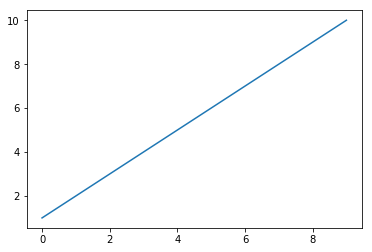

In [373]:
%matplotlib inline  

def count_stresses(stress_line):
    count_list = []
    count = 0
    for item in stress_line:
        if item is 1:    
            count = count + 1
        elif item is 0:
            count = count - 1
        else:
            pass
        count_list.append(count)

        #print(count)
        
    c = pd.Series(count_list)
    c.plot.line()
    
count_stresses(stress_line)

### Make Trees with ASCIIArt from Distance Matrices

In [271]:
def make_tree(dist_mat, file, inline=False, rooted=False):
    dm = DistanceMatrix(dist_mat)#, ids)
    
    if rooted is True:
        tree = nj(dm, disallow_negative_branch_length=False).root_at_midpoint()
    else:
        tree = nj(dm, disallow_negative_branch_length=False)

    if inline is True:
        print(tree.ascii_art())
    else:
        with open(file, 'w') as f:
            f.write(tree.ascii_art())        

In [272]:
make_tree(tfidf_phonemes, 'tree_phonemes.txt')

In [ ]:
#f('vowel')
for phon in phon_types:
    for item in phon.split():
        pass
        #print(item)
        #if item == 'cons':
        #    print('yes')
            
'cons' == 'cons'
'cons' == phon_types[0].split()[10]
#a = [f(x) for x in p.split() for p in phon_types]
#b = [f(y) for x in p.split() for y in x]